In [1]:
import cv2
import torch
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt




In [2]:
path_dir = '/Users/lukassanner/Documents/ZeissHackathon/photomask_trainingdata'

dirs = os.listdir(path_dir)[1:]

data = {}

for d in dirs:
    folder_dir = os.path.join(path_dir,d)
    files = os.listdir(folder_dir)

    tifs = []
    for f in files:
        if f.endswith('.tif'):
            tifs.append(os.path.join(folder_dir, f))
    data[d] = tifs


In [3]:
complete_data_fn = []
complete_data_labels = []
for k,key in enumerate(data.keys()):
    print(f"{key}: {len(data[key])}")
    complete_data_fn += data[key]
    complete_data_labels = np.append(complete_data_labels, (k*np.ones(len(data[key]), dtype=int)).astype(np.int))


COMPLETE FEATURE: 76
BORDERTOUCHER: 22
NO FEATURE: 13


In [4]:
label_map = {}
def label_map(index):
    index = int(index)
    if index == 0:
        return 'COMPLETE FEATURE'
    elif index == 1:
        return 'BORDERTOUCHER'
    elif index == 2:
        return 'NO FEATURE'
    else:
        return 'unkown'


In [5]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

class Photomask(Dataset):
        def __init__(self,
                    image_files,
                    label):
            self.image_files = image_files
            self.label = label
        def get_image(self, index):
            fn = self.image_files[index]
            return np.array(Image.open(fn))
            
        def __getitem__(self, index=-1):
            if index == -1:
                index = np.random.randint(self.__len__())
            return self.get_image(index), self.label[index]
    
        def __len__(self):
            return len(self.image_files)

In [6]:
def denoise(image, h = 7, block_size = 7, search_window = 21):
    return cv2.fastNlMeansDenoising(im,None,h,block_size,search_window)


In [464]:
def draw_ellipse(image, ellipses, thickness = 2, color = (255,0,0)):
    out = image.copy()
    for ell in ellipses:
        cv2.ellipse(out, ell, color, thickness)
    return out
        
def find_ellipse(image, binary_threshold = 100, contour_length=5, min_area=10, circ = 0.5):
    (t, segmentation) = cv2.threshold(image, binary_threshold, 255, cv2.THRESH_BINARY)
    contours = find_contours(segmentation)
    ellipses = []
    pi_4 = np.pi * 4
    ellipses_contour = image.copy()
    for i, contour in enumerate(contours):
        if len(contour) >= contour_length:
            area = cv2.contourArea(contour)
            if area >= min_area:  # skip ellipses smaller then 10x10

                arclen = cv2.arcLength(contour, True)
                circularity = (pi_4 * area) / (arclen * arclen)
                if circularity >= circ:
                    ellipses.append(ellipses_of_contour(contour))

    return ellipses

def find_contours(segmentation):
    _, contours, _ = cv2.findContours(segmentation, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_L1)
    return contours

def ellipses_of_contour(contour, num_cont=5):
    if len(contour) <= 5:
        return None
    return cv2.fitEllipse(contour)
    
def attributes_of_ellipses(ellipses):
    center = ellipses[0]
    axis = ellipses[1]
    angle = ellipses[2]
    area = np.pi * axis[0] * axis[1]
    return center, axis, angle, area
    


In [465]:
def fft_mag(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return 20*np.log(np.abs(fshift))

In [467]:
ds = Photomask(complete_data_fn, complete_data_labels)

im, label = ds.__getitem__()

h = 20
block_size = 10
search_window = 50

binary_threshold = 100
contour_length=5 
min_area=20
circ = 0.2

denoised = denoise(im, h=h, block_size=block_size, search_window=search_window)
print(f"std: normal {np.std(im)}, denoised {np.std(denoised)}")

ellipses = find_ellipse(denoised, binary_threshold=binary_threshold, contour_length=contour_length, min_area=min_area, circ=circ)
print(ellipses)
im_w_ell = draw_ellipse(cv2.cvtColor(im, cv2.COLOR_GRAY2RGB), ellipses, 2, (255,0,0))

f = np.fft.fft2(im)
fshift = np.fft.fftshift(f)

magnitude_spectrum = 20*np.log(np.abs(fshift))

fig, axs = plt.subplots(1,4)
axs[0].imshow(im)
axs[0].set_title(label_map(label))

axs[1].imshow(denoised)
axs[1].set_title('denoised input')

axs[2].imshow(magnitude_spectrum)
axs[2].set_title('magnitude spectrum')

axs[3].imshow(im_w_ell)
axs[3].set_title('with ellipses')

std: normal 48.921362126293054, denoised 48.88444275890215
[((243.89154052734375, 360.3089904785156), (6.300910949707031, 7.191060543060303), 51.86518478393555), ((138.07020568847656, 358.3368835449219), (6.533409118652344, 9.397665977478027), 38.09083557128906), ((88.16320037841797, 358.0314025878906), (6.280394077301025, 9.318023681640625), 33.97566223144531), ((5.421112537384033, 356.60687255859375), (6.473148822784424, 8.565513610839844), 148.84999084472656), ((347.55938720703125, 355.8551330566406), (7.106529235839844, 20.991395950317383), 103.67889404296875), ((318.0541687011719, 358.0091247558594), (6.605926513671875, 13.44286823272705), 140.65122985839844), ((268.9816589355469, 356.22259521484375), (6.3531880378723145, 8.955430030822754), 32.70038604736328), ((156.78134155273438, 354.6607666015625), (6.072414398193359, 11.965133666992188), 94.81396484375), ((14.153144836425781, 356.04608154296875), (6.423957824707031, 8.489164352416992), 148.62261962890625), ((253.3381195068359

SystemError: new style getargs format but argument is not a tuple

In [17]:
def is_border_toucher(image, ellipses):
    return 0

In [391]:
def predict(image):
    h = 10
    block_size = 5
    search_window = 50

    binary_threshold = 100
    contour_length=5 
    min_area=50
    circ = 0.2

    denoised = denoise(im, h=h, block_size=block_size, search_window=search_window)

    
    ellipses = find_ellipse(denoised, binary_threshold=binary_threshold, contour_length=contour_length, min_area=min_area, circ=circ)
    
    return 2, ellipses

[]


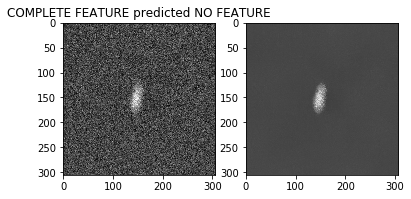

In [392]:

im, label = ds.__getitem__()
state, ellipses = predict(im)
out = im.copy()
if ellipses is not None:
    print([p for p in ellipses])
    im = draw_ellipse(cv2.cvtColor(im, cv2.COLOR_GRAY2RGB), ellipses, 2, (255,0,0))
fig, axs = plt.subplots(1,2)
axs[0].imshow(im)
axs[0].set_title(label_map(label) + " predicted " + label_map(state))
binary_threshold = 100
contour_length=5 
min_area=20
circ = 0.2

out = denoise(out, h=h, block_size=block_size, search_window=search_window)

axs[1].imshow(out)


In [261]:
np.std(denoised)

49.40248073403462

In [406]:
labels = []
images = []
softs = []
mags = []
laplacians = []
for k in range(ds.__len__()):
    print((k+1)/ds.__len__())
    im, label = ds.__getitem__(k)
    denoised = denoise(im, h=h, block_size=block_size, search_window=search_window)
    mag = fft_mag(denoised)
    lap = cv2.Laplacian(im,cv2.CV_64F)
    
    images.append(im)
    softs.append(denoised)
    mags.append(mag)
    laplacians.append(lap)
    
    labels.append(label)

0.009009009009009009
0.018018018018018018
0.02702702702702703
0.036036036036036036
0.04504504504504504
0.05405405405405406
0.06306306306306306
0.07207207207207207
0.08108108108108109
0.09009009009009009
0.0990990990990991
0.10810810810810811
0.11711711711711711
0.12612612612612611
0.13513513513513514
0.14414414414414414
0.15315315315315314
0.16216216216216217
0.17117117117117117
0.18018018018018017
0.1891891891891892
0.1981981981981982
0.2072072072072072
0.21621621621621623
0.22522522522522523
0.23423423423423423
0.24324324324324326
0.25225225225225223
0.26126126126126126
0.2702702702702703
0.27927927927927926
0.2882882882882883
0.2972972972972973
0.3063063063063063
0.3153153153153153
0.32432432432432434
0.3333333333333333
0.34234234234234234
0.35135135135135137
0.36036036036036034
0.36936936936936937
0.3783783783783784
0.38738738738738737
0.3963963963963964
0.40540540540540543
0.4144144144144144
0.42342342342342343
0.43243243243243246
0.44144144144144143
0.45045045045045046
0.45945945

/Users/lukassanner/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


0.9009009009009009
0.9099099099099099
0.918918918918919
0.9279279279279279
0.9369369369369369
0.9459459459459459
0.954954954954955
0.963963963963964
0.972972972972973
0.9819819819819819
0.990990990990991
1.0


In [407]:
indexes = []
for k in range(3):
    indexes.append(np.array([i for i, e in enumerate(labels) if e == k]))


In [408]:
indexes


[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75]),
 array([76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
        93, 94, 95, 96, 97]),
 array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110])]

In [409]:
lap_var = np.array([np.var(l) for l in laplacians if not np.isinf(l.any())])
mag_var = np.array([np.var(m) for m in mags if not np.isinf(m.any())])

/Users/lukassanner/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Text(0.5, 1.0, 'fft magnitude')

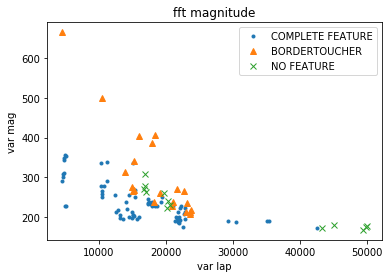

In [410]:
fig, ax = plt.subplots()
signs = ['.', '^', 'x']
for k in range(3):
    ax.plot(lap_var[indexes[k]], mag_var[indexes[k]], signs[k], label=label_map(k))
ax.set_xlabel('var lap')
ax.set_ylabel('var mag')
ax.legend()
ax.set_title('fft magnitude')

Text(0.5, 1.0, 'denoised')

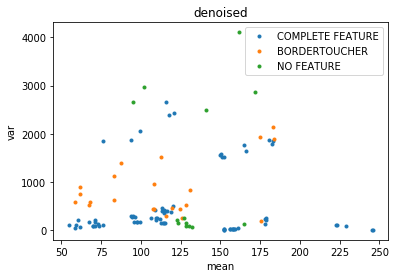

In [92]:
fig, ax = plt.subplots()

for k in range(3):
    ax.plot(noise_mean[indexes[k]], noise_var[indexes[k]], '.', label=label_map(k))
ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.legend()
ax.set_title('denoised')

Text(0.5, 1.0, 'normal')

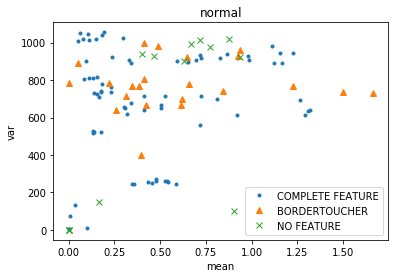

In [196]:
fig, ax = plt.subplots()

for k in range(3):
    ax.plot(np.abs(normal_mean[indexes[k]] - noise_mean[indexes[k]]), np.abs(normal_var[indexes[k]] - noise_var[indexes[k]]), signs[k], label=label_map(k))
ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.legend()
ax.set_title('normal')

In [249]:
mag_std_vals[indexes[1]]

array([13.60838265, 13.37779485, 14.16352034, 13.80614707, 13.82708392,
       13.98296518, 14.338199  , 15.21185903, 15.14723726, 16.06390719,
       13.73713391, 14.70970292, 15.16924086, 13.36356231, 13.35230078,
       13.29184257, 16.27199278, 14.03433033, 15.2357608 , 13.58142206,
       13.43007238,         nan])

21897.014703915032 COMPLETE FEATURE


Text(0.5, 1.0, 'COMPLETE FEATURE')

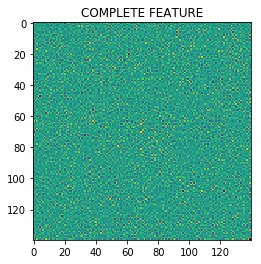

In [250]:
im, label = ds.__getitem__()
#im = denoise(im)
im = cv2.Laplacian(im,cv2.CV_64F)
print(np.var(im), label_map(label))
plt.imshow(im)
plt.title(label_map(label))

In [254]:
can_mean = []
can_var = []

for k in range(ds.__len__()):
    im, label = ds.__getitem__(k)
    denoised = denoise(im, h=h, block_size=block_size, search_window=search_window)
    #mag = fft_mag(im)
    can = cv2.Laplacian(denoised,cv2.CV_64F)
    can_mean.append(np.mean(can))
    can_var.append(np.var(can))
  


In [255]:
can_mean = np.array(can_mean) 
can_var = np.array(can_var)



Text(0.5, 1.0, 'denoised')

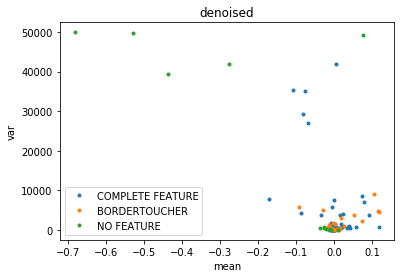

In [256]:

fig, ax = plt.subplots()

for k in range(3):
    ax.plot(can_mean[indexes[k]], can_var[indexes[k]], '.', label=label_map(k))
ax.set_xlabel('mean')
ax.set_ylabel('var')
ax.legend()
ax.set_title('denoised')

In [459]:
binary_threshold = 120

h = 5
block_size = 50
search_window = 50

In [468]:
im, label = ds.__getitem__()

denoised_im = denoise(im, h=h, block_size=block_size, search_window=search_window)
edges = cv2.Canny(denoised_im, 10,10)
(t, segmentation) = cv2.threshold(denoised_im, binary_threshold, 255, cv2.THRESH_BINARY)
contours = find_contours(segmentation)
draw_on_image = cv2.cvtColor(im.copy(), cv2.COLOR_GRAY2RGB)
for c in contours:
    if cv2.contourArea(c)>10:
        ellipses = ellipses_of_contour(c)
        if ellipses is not None:
            draw_on_image = draw_ellipse(draw_on_image, ellipses, color=(255,0,0))

fig, axs = plt.subplots(1,5)
print(label_map(label))
axs[0].imshow(im)
axs[1].imshow(denoised_im)
axs[2].imshow(segmentation)
axs[3].imshow(edges)
axs[4].imshow(draw_on_image)

TypeError: function takes exactly 3 arguments (2 given)